### Evaluación del modelo en condiciones aproximadas a producción
(estimación de rentabilidad del sistema)

#### Importamos librerías necesarias

In [1]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent dir

In [2]:
import pickle
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
df_2024 = pd.read_parquet("../clean/df_2024.parquet")
df_2024[(df_2024.dia == 7) & (df_2024.mes == 5)]

Cargamos los datos de forecast

In [5]:
df_forecast = pd.read_csv('../clean/forecast_merged.csv')

In [6]:
df_forecast.columns

Index(['Vviento', 'PeriodoOlas', 'Nubosidad', 'Lluvia', 'antelacion', 'hora',
       'dia', 'anio', 'mes', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure',
       'vis', 'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE',
       'wdir_N', 'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S',
       'wdir_SE', 'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W',
       'wdir_WNW', 'wdir_WSW', 'moonphase', 'AlturaOlas'],
      dtype='object')

In [7]:
antelaciones = df_forecast['antelacion'] # guardamos para evaluar posteriormente

#### Separamos en explicativas y respuesta

In [8]:
X, y = df_forecast.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_forecast['AlturaOlas']

#### Cargamos el modelo definitivo

In [9]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

model

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestRegressor(max_depth=28, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=201, random_state=777)

Obtenemos la escala de los datos de entrenamiento

In [10]:
filename = '../modelos/modelo_definitivo/scaler.pkl'

with open(filename, 'rb') as file:
    scaler = pickle.load(file)


scaler

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle es

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [11]:
len(y)

4428

In [12]:
filtro_observaciones_reales = ~y.isna()
filtro_observaciones_reales.sum()

1011

Para medir el éxito de las predicciones necesitamos esperar hasta que el suceso se haya dado y comparar. Es decir, para comprobar cómo de buena ha sido nuestra predicción de las olas a las 14h necesitamos que pasen las 14h, recoger la altura real y compararlo con nuestra predicción.

Es por eso que nuestra columna y (AlturaOlas) tiene muchos NaNs, pues se tratan de observaciones que son futuras al momento actual.

Para hacer el análisis únicamente podemos usar datos que ya han sido confirmados. En un futuro cuando las predicciones tengan un valor real con el cual compararse, obtendremos un mayor espacio de predicciones con el cual medir el rendimiento del modelo.

In [14]:
X_obs_reales = X[filtro_observaciones_reales]
y_obs_reales = y[filtro_observaciones_reales]
antelacion_obs_reales = antelaciones[filtro_observaciones_reales]

In [15]:
# predicciones = model.predict(X)
predicciones_obs_reales = model.predict(scaler.transform(X_obs_reales))

In [16]:
# calcular_metricas(y, predicciones)
calcular_metricas(y_obs_reales, predicciones_obs_reales)

{'TEST_MAX_ERROR': 0.6023284875710251,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.16658823290958938,
 'TEST_MEDIAN_ABS_ERROR': 0.10911256791853846,
 'TEST_MEAN_ABS_ERROR': 0.1319627613510081}

Text(0.5, 0, 'TRUE (metros)')

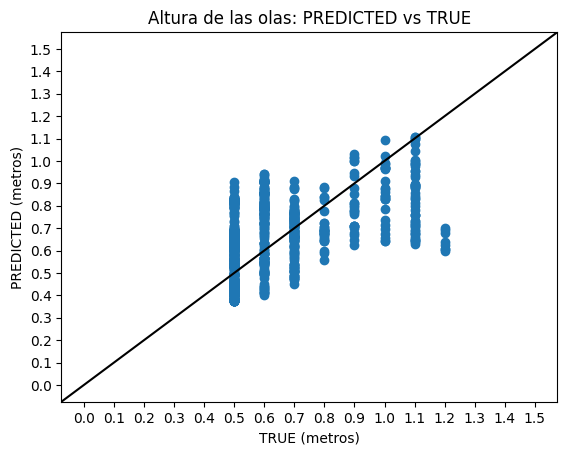

In [17]:
plt.scatter(y_obs_reales, predicciones_obs_reales)
plt.xticks([i/10 for i in range(0,16)])
plt.yticks([i/10 for i in range(0,16)])
plt.axline([0,0], [1.5, 1.5], color='0')
plt.title('Altura de las olas: PREDICTED vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')

#### Ahora pasaríamos a analizar el error en función de la antelación de la predicción

In [21]:
def rmse(y, predicciones):
    return np.sqrt(((y-predicciones)**2).sum())

In [22]:
rmse(y_obs_reales[antelacion_obs_reales == 25], predicciones_obs_reales[antelacion_obs_reales == 25])

0.738352618786684

In [23]:
antelaciones_ordenadas = np.sort(antelacion_obs_reales.unique())

antelaciones_ordenadas = antelaciones_ordenadas.astype(int)

In [24]:
df_evaluacion = pd.DataFrame(columns = ["antelacion","RMSE", "num_preds"])
# df_evaluacion.loc[len(df_evaluacion)] = [4, 'D']
df_evaluacion

,antelacion,RMSE,num_preds


In [25]:
import matplotlib.pyplot as plt

for i in antelaciones_ordenadas:
    df_evaluacion.loc[len(df_evaluacion)] = [i, rmse(y_obs_reales[antelacion_obs_reales == i], predicciones_obs_reales[antelacion_obs_reales == i]), len(antelacion_obs_reales == i)]

In [26]:
df_evaluacion.antelacion = df_evaluacion.antelacion.astype(int)

In [27]:
df_evaluacion.num_preds = df_evaluacion.num_preds.astype(int)

([<matplotlib.axis.XTick at 0x1393b7dd0>,
 [Text(0, 0, '0'),
  Text(3, 0, '3'),
  Text(6, 0, '6'),
  Text(9, 0, '9'),
  Text(12, 0, '12'),
  Text(15, 0, '15'),
  Text(18, 0, '18'),
  Text(21, 0, '21'),
  Text(24, 0, '24'),
  Text(27, 0, '27'),
  Text(30, 0, '30'),
  Text(33, 0, '33'),
  Text(36, 0, '36'),
  Text(39, 0, '39'),
  Text(42, 0, '42'),
  Text(45, 0, '45'),
  Text(48, 0, '48'),
  Text(51, 0, '51'),
  Text(54, 0, '54'),
  Text(57, 0, '57'),
  Text(60, 0, '60')])

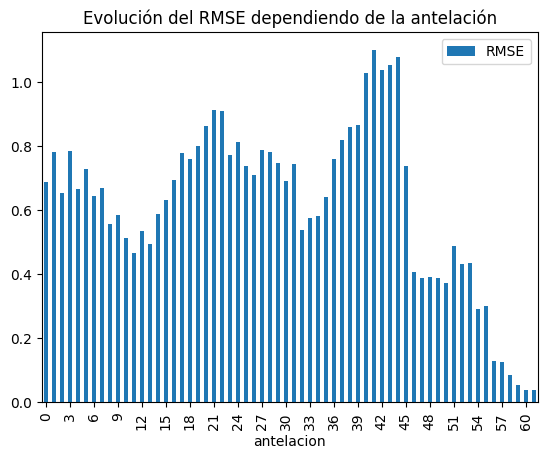

In [31]:
df_evaluacion.plot(kind = "bar", x = "antelacion", y = "RMSE", title = "Evolución del RMSE dependiendo de la antelación");
plt.xticks([i for i in range(0,df_evaluacion.antelacion.max() + 1, 3)])

Comparación del rendimiento usando datos reales vs predicciones
-

In [35]:
df_2024 = pd.read_parquet("../clean/df_2024.parquet")

df_forecast = pd.read_csv('../clean/forecast_merged.csv')

In [37]:
y = df_forecast['AlturaOlas']

In [38]:
filtro_observaciones_reales = ~y.isna() #Predicciones que ya tienen una confirmacion real
filtro_observaciones_reales.sum()

1011

Nos quedamos con las fechas únicas que tienen confirmación real

In [49]:
fechas = df_forecast[filtro_observaciones_reales][['anio', 'mes', 'dia', 'hora']].drop_duplicates()
fechas.shape

(118, 4)

Hacemos el inner join con esto para quedarnos solo con filas que estan en ambas tablas

In [51]:
#Seleccionamos únicamente los datos reales que coinciden con las predicciones. 
# Como los datos reales acaban un poco antes que las predicciones no hace falta acotar por encima
X_obs_reales = df_2024.merge(fechas, on=['anio', 'mes', 'dia', 'hora'])
X_obs_reales.shape

(68, 38)

In [56]:
#Construimos un df para predecir con los datos reales, y guardamos el valor real de la altura de la ola.
X_obs_reales_limpio = X_obs_reales.drop(columns=['anio', 'mes', 'dia', 'hora', 'Temperatura', 'wspd', 'AlturaOlas']) 
y_reales = X_obs_reales["AlturaOlas"]

In [57]:
X_obs_reales_limpio.columns

Index(['moonphase', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis',
       'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE',
       'wdir_N', 'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S',
       'wdir_SE', 'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W',
       'wdir_WNW', 'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia',
       'Nubosidad'],
      dtype='object')

In [58]:
# predecimos con los datos reales escalando los datos
predicciones_usando_datos_reales = model.predict(scaler.transform(X_obs_reales_limpio))

In [59]:
calcular_metricas(y_reales, predicciones_usando_datos_reales)

{'TEST_MAX_ERROR': 0.4768470024999871,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.19601692888137937,
 'TEST_MEDIAN_ABS_ERROR': 0.11210633686379906,
 'TEST_MEAN_ABS_ERROR': 0.15201346613399613}

In [66]:
df_forecast_fechas_iguales = df_forecast.merge(X_obs_reales[['anio', 'mes', 'dia', 'hora']], on=['anio', 'mes', 'dia', 'hora'])
# vemos el numero de filas para ver si coincide de fechas (descartamos duplicados de antelacion)
df_forecast_fechas_iguales.drop_duplicates(['anio', 'mes', 'dia', 'hora']).shape

(68, 37)

In [67]:
y_forecast = df_forecast_fechas_iguales["AlturaOlas"]
df_forecast_fechas_iguales = df_forecast_fechas_iguales.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora'])

In [70]:
predicciones_forecast = model.predict(scaler.transform(df_forecast_fechas_iguales))

In [71]:
calcular_metricas(y_forecast, predicciones_forecast)

{'TEST_MAX_ERROR': 0.5742213977288604,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.15671852379490175,
 'TEST_MEDIAN_ABS_ERROR': 0.09663322926382639,
 'TEST_MEAN_ABS_ERROR': 0.12290703631349999}

In [72]:
#Volvemos a copiar la celda
calcular_metricas(y_reales, predicciones_usando_datos_reales)

{'TEST_MAX_ERROR': 0.4768470024999871,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.19601692888137937,
 'TEST_MEDIAN_ABS_ERROR': 0.11210633686379906,
 'TEST_MEAN_ABS_ERROR': 0.15201346613399613}

In [75]:
df_results = pd.DataFrame([calcular_metricas(y_reales, predicciones_usando_datos_reales), calcular_metricas(y_forecast, predicciones_forecast)])
df_results['DATOS'] = ['OBS', 'FORECAST']
df_results

,TEST_MAX_ERROR,TEST_ROOT_MEAN_SQ_ERROR,TEST_MEDIAN_ABS_ERROR,TEST_MEAN_ABS_ERROR,DATOS
0,0.476847,0.196017,0.112106,0.152013,OBS
1,0.574221,0.156719,0.096633,0.122907,FORECAST


Comprobamos que el modelo tiene mejores métricas si predecimos sobre datos reales en vez de predicciones, aunque podemos ver que el error añadido de las predicciones explicativas no es muy elevado, únicamente afecta en décimas a una métrica. La métrica más afectada es TEST_MAX_ERROR, puesto que el resto de métricas dan mejores resultados incluso usando predicciones sobre las variables explicativas.

NOTA: Para comparar estos datos hemos usado las mismas observaciones temporales, pero en un caso con datos de predicciones y en el otro caso con datos reales.